In [2]:
# Import sympy for symbolic calculations
import sympy as sp
import numpy as np
import mpmath as mp

import matplotlib.pyplot as plt

# Import InflationPy package

from inflationpy import SlowRollModel, SlowRollEndSolver, SlowRollStartSolver
from inflationpy import FunctionAsolver, FunctionBsolver, FunctionVsolver
from inflationpy import NFoldCorrection, ModelCompare

from IPython.display import display, Math, Latex

In [3]:
phi = sp.Symbol('phi', real=True)
p, xi, M_p, N = sp.symbols('p xi M_p N', real=True, positive=True)
I_phi = sp.symbols('I_phi', real=True)

# Define theory

In [4]:
A = 1 + xi * (phi / M_p) ** 2
B = "1"
V_palatini = sp.simplify(A**2 * xi ** (-p / 2) * sp.asinh(sp.sqrt(xi) * phi / M_p) ** p)

I_V = (I_phi / M_p) ** p

V_metric = sp.simplify(
    (
        I_V.subs(
            I_phi,
            M_p
            / sp.sqrt(xi)
            * (
                sp.sqrt(6 * xi + 1) * sp.asinh(sp.sqrt(xi * (6 * xi + 1)) * phi / M_p)
                - sp.sqrt(6 * xi) * sp.atanh(sp.sqrt(6) * xi / sp.sqrt(xi * (6 * xi + 1) * phi**2 + M_p**2) * phi)
            ),
        )
        * A**2
    )
)


In [5]:
# Initiation takes some time ~ 130 sec
metric = SlowRollModel(A=A, B=B, V=V_metric, I_V=I_V, palatini=False)
palatini = SlowRollModel(A=A, B=B, V=V_palatini, I_V=I_V, palatini=True)


In [6]:
metric.A.f_s()

1 + phi**2*xi/M_p**2

In [7]:
metric.B.f_s()

1

In [8]:
palatini.V.f_s()

(asinh(phi*sqrt(xi)/M_p)/sqrt(xi))**p*(M_p**2 + phi**2*xi)**2/M_p**4

In [9]:
metric.V.f_s()

(M_p**2 + phi**2*xi)**2*(-sqrt(6)*atanh(sqrt(6)*phi*xi/sqrt(M_p**2 + 6*phi**2*xi**2 + phi**2*xi)) + sqrt(6*xi + 1)*asinh(phi*sqrt(xi)*sqrt(6*xi + 1)/M_p)/sqrt(xi))**p/M_p**4

In [10]:
metric.I_V.f_s()

(I_phi/M_p)**p

In [11]:
x = np.linspace(-5, 5, 1000)
y1= palatini.V.f_n(x, p=2, xi=1, M_p=1)
y2= metric.V.f_n(x, p=2, xi=1, M_p=1)
y11 = palatini.V.f_n(x, p=2, xi=1, M_p=1)/palatini.A.f_n(x, p=2, xi=1, M_p=1)**2
y22 = metric.V.f_n(x, p=2, xi=1, M_p=1)/metric.A.f_n(x, p=2, xi=1, M_p=1)**2
y3 = metric.I_V.f_n(x, p=2, xi=1, M_p=1)

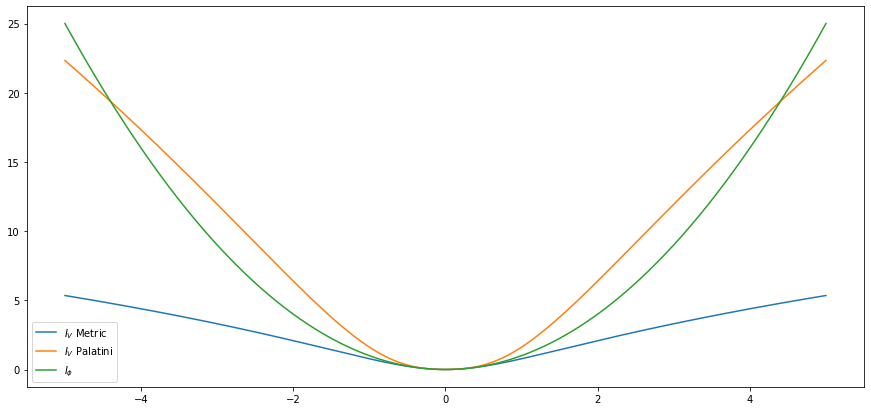

In [12]:
plt.figure(figsize=(15, 7))
#plt.plot(x, y1, label='Palatini')
#plt.plot(x, y2, label='Metric')
plt.plot(x, y11, label='$I_V$ Metric')
plt.plot(x, y22, label='$I_V$ Palatini')
plt.plot(x, y3, label="$I_\phi$")
plt.legend()

In [11]:
metric.I_V.f_s()

(I_phi/M_p)**p

In [12]:
# Simplify only functions and not their derivatives
#metric.simplify() # Takes a more time than palatin as metric formalism is more complex
metric.simplify(inverse=True)
palatini.simplify()
#palatini.simplify(inverse=True)

In [13]:
palatini.inspect();

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Compare $I_V$ and $(A, B, V)$ theories

In [17]:
compare_metric = ModelCompare(metric)
compare_palatini = ModelCompare(palatini)

#### Compare invariant potentials (Palatini)

For these functions it can be done analytically

In [18]:
invariant_scalar_field = compare_palatini.solve_invariant_field()
potential1, potential2 = compare_palatini.compare_invariant_potential(invariant_scalar_field, simplify=True)

In [19]:
# Calculated using V/A**2
display(potential1)
# Calclated using I_V(I_phi)
display(potential2)

(asinh(phi*sqrt(xi)/M_p)/sqrt(xi))**p

(asinh(phi*sqrt(xi)/M_p)/sqrt(xi))**p

#### Compare invariant scalar field (Palatini)

For these functions it can be done analytically

In [20]:
inverse_invariant_potential = compare_palatini.solve_I_V_inverse()

In [21]:
field1, field2 = compare_palatini.compare_invariant_field(inverse_invariant_potential[0], simplify=True)

In [24]:
# Calculated using potential inverse function
display(field1)
# Calclated using I_phi definition
display(field2)

M_p*(asinh(phi*sqrt(xi)/M_p)**p)**(1/p)/sqrt(xi)

M_p*asinh(phi*sqrt(xi)/M_p)/sqrt(xi)

#### Compare invariant potentials (Metric)

For these functions it must be done numerically

In [79]:
interval = [0, 5]
x = np.linspace(interval[0], interval[1] , 100)
metric_invariant_field_mp = compare_metric.nsolve_field_mp(interval, 0, params={M_p:1, xi:1, p:2})
inverse_mp = sp.lambdify(compare_metric.IV_symbol, compare_metric.solve_I_V_inverse(params={p:2, M_p:1})[0], 'mpmath')
metric_invariant_field_np = compare_metric.nsolve_field_np(interval, 0, params={M_p:1, xi:1, p:2}, sc_kwargs=dict(method='LSODA', atol=1e-4, rtol=1e-4, t_eval=x))
inverse_np = sp.lambdify(compare_metric.IV_symbol, compare_metric.solve_I_V_inverse(params={p:2, M_p:1})[0], 'scipy')


In [80]:
potential1, potential2 = compare_metric.compare_invariant_potential_mp(x, metric_invariant_field_mp, params={M_p:1, xi:1, p:2})
potential3, potential4 = compare_metric.compare_invariant_potential_np(x, metric_invariant_field_np, params={M_p:1, xi:1, p:2})

In [81]:
scalar_field1, scalar_field2 = compare_metric.compare_invariant_field_mp(x, inverse_mp, metric_invariant_field_mp, params={M_p:1, xi:1, p:2})
scalar_field3, scalar_field4 = compare_metric.compare_invariant_field_np(x, inverse_np, metric_invariant_field_np, params={M_p:1, xi:1, p:2})

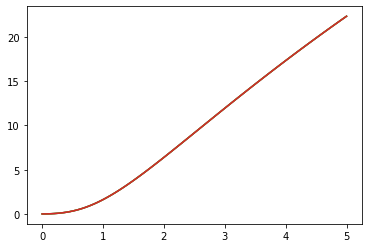

In [72]:
plt.plot(x, potential1)
plt.plot(x, potential2)
plt.plot(x, potential3)
plt.plot(x, potential4)

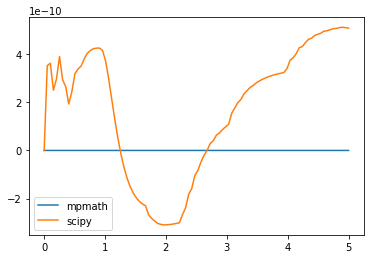

In [75]:
plt.plot(x, np.array(scalar_field1) - np.array(scalar_field3), label='mpmath')
#plt.plot(x, scalar_field2)
plt.plot(x, np.array(scalar_field2) - np.array(scalar_field4), label='scipy')
#plt.plot(x, scalar_field4)
#plt.yscale('log')
plt.legend()

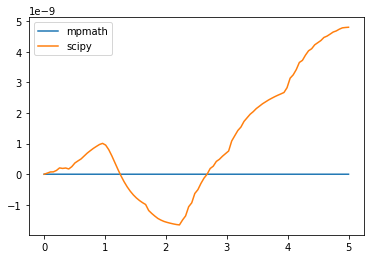

In [78]:
# plt.plot(x, potential1, label='mpmath, $V/A^2$')
# plt.plot(x, potential2, label='mpmath, calculated $I_\phi$')
# plt.plot(x, potential3, label='numpy, $V/A^2$')
# plt.plot(x, potential4, label='numpy, calculated $I_\phi$')
plt.plot(x, np.array(potential1) - np.array(potential3), label='mpmath')
plt.plot(x, np.array(potential2) - np.array(potential4), label='scipy')
#plt.yscale('log')
plt.legend()

# Calculate observables

## End solver

In [18]:
end_solver_palatini = SlowRollEndSolver(model=palatini)
end_solver_metric = SlowRollEndSolver(model=metric)
end_solver_invariant = SlowRollEndSolver(model=metric, invariant=True)

In [19]:
parameters = {M_p:1, p:2, xi:1}
field_interval = [0, 5]
end_value_palatini = end_solver_palatini.nsolve_mp(field_interval, params=parameters)
print(f"For interval in {field_interval} solutions for palatini are: {' '.join([str(x) for x in end_value_palatini])}")
end_value_metric = end_solver_metric.nsolve_mp(field_interval, params=parameters)
print(f"For interval in {field_interval} solutions for metric are: {' '.join([str(x) for x in end_value_metric])}")
end_value_invariant = end_solver_invariant.nsolve_mp(field_interval, params=parameters)
print(f"For interval in {field_interval} solutions for invariant are: {' '.join([str(x) for x in end_value_invariant])}")

For interval in [0, 5] solutions for palatini are: 1.93506682217436
For interval in [0, 5] solutions for metric are: 1.1012939771279
For interval in [0, 5] solutions for invariant are: 1.4142135623731


## Start solver

In [20]:
initial_solver_palatini = SlowRollStartSolver(model=palatini)
initial_solver_metric = SlowRollStartSolver(model=metric)
initial_solver_invariant = SlowRollStartSolver(model=metric, invariant=True)

In [21]:
def return_values(function, N_values):
    result = [function(x) for x in N_values]
    string_result = ' '.join([f'N={N_value}: {x}' for N_value, x in zip(N_values, result)])
    return result, string_result

N_values = [50, 60]
initial_value_palatini_f = initial_solver_palatini.nsolve_mp(end_value_palatini[-1], params=parameters)
palatini_initial, palatini_initial_str = return_values(initial_value_palatini_f, N_values)
print(f"Solutions for palatini are: {palatini_initial_str}")
initial_value_metric_f = initial_solver_metric.nsolve_mp(end_value_metric[-1], params=parameters)
metric_initial, metric_initial_str = return_values(initial_value_metric_f, N_values)
print(f"Solutions for palatini are: {metric_initial_str}")
initial_value_invariant_f = initial_solver_invariant.nsolve_mp(end_value_invariant[-1], params=parameters)
invariant_initial, invariant_initial_str = return_values(initial_value_invariant_f, N_values)
print(f"Solutions for palatini are: {invariant_initial_str}")

Solutions for palatini are: N=50: 743796.848167858 N=60: 2851061.68960545
Solutions for palatini are: N=50: 183.697024357317 N=60: 305.258638628391
Solutions for palatini are: N=50: 14.2126704035519 N=60: 15.556349186104


# Observable values

## $n_s$ and $r$

In [22]:
def return_observables(model, initial_values, N_values, invariant, params):
    result_r = [model.calculate_r_mp(initial_value, params=params, invariant=invariant) for initial_value in initial_values]
    result_ns = [model.calculate_ns_mp(initial_value, params=params, invariant=invariant) for initial_value in initial_values]

    str_r = [f"N={N_value}: {r_value}" for N_value, r_value in zip(N_values, result_r)]
    str_ns = [f"N={N_value}: {ns_value}" for N_value, ns_value in zip(N_values, result_ns)]
    return str_ns, str_r


palatini_ns, palatini_r = return_observables(palatini, palatini_initial, N_values, False, parameters)

print(f"n_s values for palatini: {' '.join(palatini_ns)}")
print(f"r values for palatini: {' '.join(palatini_r)}")

metric_ns, metric_r = return_observables(metric, metric_initial, N_values, False, parameters)
print(f"n_s values for metric: {' '.join(metric_ns)}")
print(f"r values for metric: {' '.join(metric_r)}")

invariant_ns, invariant_r = return_observables(metric, invariant_initial, N_values, True, parameters)

print(f"n_s values for invariant: {' '.join(invariant_ns)}")
print(f"r values for invariant: {' '.join(invariant_r)}")

n_s values for palatini: N=50: 0.96039603960396 N=60: 0.966942148760331
r values for palatini: N=50: 0.158415841584158 N=60: 0.132231404958678
n_s values for metric: N=50: 0.96039603960396 N=60: 0.96694214876033
r values for metric: N=50: 0.158415841584158 N=60: 0.132231404958677
n_s values for invariant: N=50: 0.96039603960396 N=60: 0.966942148760331
r values for invariant: N=50: 0.158415841584158 N=60: 0.132231404958678
